Load data

In [1]:
import pandas as pd
import numpy as np

import os
from pathlib import Path
dir = Path(os.path.abspath('../workflow')) # sets dir variable

df = pd.read_csv(dir / "data/expression.txt", sep='\t' )
df.columns = df.columns.str.strip()

labels = pd.read_csv(dir / "data/sample info.txt", sep='\t')
labels.set_index(labels.columns[0], inplace=True)
labels = labels.transpose()

Filter by bird type

In [2]:
target = "areaX"

print(len(df.columns), len(df))

for col_name in df:
    bird_type = labels.loc[labels['Sample_number'] == col_name].index[0]
    
    if (target not in bird_type):
        df = df.drop(col_name, axis=1)
        
print(len(df.columns), len(df))

54 20104
27 20104


Replaces na values with 0, and removes columns with low sums

In [3]:
order_of_magnitude = 2

print(len(df.columns), len(df))

df.fillna(0)

sums = {col_name : np.sum(col_data) for col_name, col_data in df.items()}
median = np.median(list(sums.values()))

for col_name, col_data in df.items():
    sum = sums[col_name]
    ratio = sum/median
    
    if (ratio > (10 ** order_of_magnitude) or ratio < (10 ** -order_of_magnitude)):
        df = df.drop(col_name, axis=1)
        
print(len(df.columns), len(df))

27 20104
26 20104


Filter by standard deviation

In [4]:
num_deviations = 2

print(len(df.columns), len(df))

means_and_devs = {col_name : (np.mean(col_data), np.std(col_data)) for col_name, col_data in df.items()}

for col_name, col_data in df.items():
    mean, dev = means_and_devs[col_name]

    upper_bound = mean + (dev * num_deviations)
    lower_bound = mean - (dev * num_deviations)
    
    for idx, item in col_data.items():
        if (item < lower_bound or item > upper_bound):
            df.at[idx, col_name] = np.nan
            
df = df.dropna()

print(len(df.columns), len(df))

26 20104
26 16748


Import the dataframe into R

In [5]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Initialize R
r = robjects.r
pandas2ri.activate()

# Convert df dataframe to an r dataframe
r_df = pandas2ri.py2rpy(df)

Normalize with limma (EXCLUSIVE TO MICROARRAYS)

In [6]:
from rpy2.robjects.packages import importr

df_old = df.copy()

limma = importr('limma')
df_norm = limma.normalizeBetweenArrays(df, method="quantile")
df[:] = df_norm

Filter with GWENA

In [7]:
gwena = importr('GWENA')
print(df)

print(df.shape)
print(robjects.r['is_data_expr'](df))
df_filter = gwena.filter_low_var(df)
print(pd.DataFrame(df_filter).shape)

           GSM855822    GSM855824    GSM855826     GSM855828     GSM855830  \
2757075  1492.646128  1373.826792  1318.428950   1390.424368   1567.209797   
2757076  6004.072706  6666.570034  5521.642614  11294.565344   4934.175911   
2757077  7798.522702  6539.634600  6231.197113   5693.742649   5876.085149   
2757078  8602.605748  6356.183040  9341.059279  12017.693408  10025.840310   
2757080  1723.583764  1733.556777  1259.760183   1349.092126   1227.831579   
...              ...          ...          ...           ...           ...   
2800048   828.091994   546.009806   731.110895    741.928493    932.479316   
2800049   579.867897   446.343066   378.190188    845.426071    490.130288   
2800050    29.538775    44.509152    53.744304     75.554648     49.442003   
2800051  4783.258225  4734.291433  2327.910475   2577.452494   2954.258458   
2800052  1323.192064   944.589262   620.722965    489.308367   1862.957775   

            GSM855832     GSM855836    GSM855838     GSM855840 

Initialize CEMiTool

In [8]:
cemitool = importr('CEMiTool')
doParallel = importr('doParallel')

doParallel.registerDoParallel(cores = 8)
print("Classes and parallel initialized")

Classes and parallel initialized


Run CEMiTool and generate outputs

In [9]:
df_filter = pd.DataFrame(df_filter).transpose()
cem = cemitool.cemitool(df_filter, plot=True, verbose=True)

# cemitool.generate_report(cem, force=True)
# cemitool.write_files(cem, force=True)
# cemitool.save_plots(cem, "all", force=True)

R[write to console]: Plotting diagnostic plots ...

R[write to console]: ...Plotting mean and variance scatterplot ...

R[write to console]: ...Plotting expression histogram ...

R[write to console]: ...Plotting qq plot ...

R[write to console]: ...Plotting sample tree ...

R[write to console]: Finding modules ...

R[write to console]: Selecting Beta



pickSoftThreshold: will use block size 1301.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1301 of 1301
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.  Density
1      1   0.2280  0.763          0.756 457.000   469.000  686.0 0.352000
2      2   0.0879 -0.300          0.815 218.000   214.000  433.0 0.168000
3      3   0.4330 -0.660          0.953 119.000   109.000  295.0 0.091700
4      4   0.6390 -0.895          0.985  70.900    60.700  210.0 0.054500
5      5   0.7530 -1.060          0.989  44.700    35.900  155.0 0.034400
6      6   0.8380 -1.200          0.992  29.500    22.000  117.0 0.022700
7      7   0.8770 -1.290          0.996  20.100    14.100   91.6 0.015500
8      8   0.8850 -1.400          0.986  14.200     9.270   72.8 0.010900
9      9   0.8820 -1.510          0.975  10.300     6.260   58.7 0.007900
10    10   0.8870 -1.560          0.967   7.600     4.330   48.0 0.005850
11    12   0.9180 -1.630       

R[write to console]: Merging modules based on eigengene similarity



 mergeCloseModules: Merging modules whose distance is less than 0.2
   Calculating new MEs...


R[write to console]: Plotting beta x R squared curve ...

R[write to console]: Plotting mean connectivity curve ...

R[write to console]: Generating profile plots ...

R[write to console]: Plotting beta x R squared curve ...

R[write to console]: Plotting mean connectivity curve ...



/var/folders/7h/sr6tmjsj3f3fzzdz59gnkbk80000gn/T/ipykernel_57528/171461875.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hierarchical_clustering = linkage(distance_matrix, method='complete')
/var/folders/7h/sr6tmjsj3f3fzzdz59gnkbk80000gn/T/ipykernel_57528/171461875.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


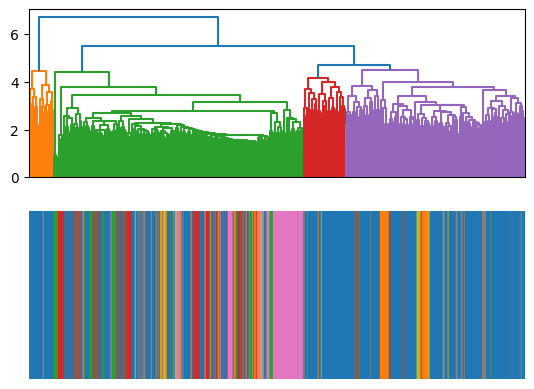

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

expression_data = cemitool.module_genes(cem)
adjacency_matrix = cemitool.adj_data(cem)
distance_matrix = 1 - adjacency_matrix

hierarchical_clustering = linkage(distance_matrix, method='complete')

fig, axes = plt.subplots(nrows=2)

color_mapping = {
    "M1": "red",
    "M2": "blue",
    "M3": "green"
}

# Plot the dendrogram
dendro = dendrogram(hierarchical_clustering, labels=expression_data[0], no_labels=True, ax=axes[0])

# Get the leaf node ids
leaf_ids = dendro['leaves']

modules = np.array(expression_data[1])[leaf_ids]

# Create a list of unique labels in the order they first appear in the array
unique_labels = []
for label in modules:
    if label not in unique_labels:
        unique_labels.append(label)

# Assign each unique label a color
colors = plt.cm.get_cmap('tab10', len(unique_labels))
label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

# Create an array of colors for each element in the original array
color_array = [label_to_color[label] for label in modules]


# # Create a color bar
# fig, ax = plt.subplots(figsize=(8, 1), dpi=80)
ax = axes[1]

for i, color in enumerate(color_array):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(modules))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()